In [1]:
import pandas as pd
import numpy as np

In [2]:
airports = pd.read_csv("../map1_points/airports.csv",
                       delimiter=',',
                       names=['id', 'name', 'city', 'country', 'iata', 'icao', 'lat', 'long', 'altitude', 'timezone',
                              'dst', 'tz', 'type', 'source'])
routes = pd.read_csv("routes.csv",
                       delimiter=',',
                       names=['airline', 'id', 'source_airport', 'source_airport_id', 'destination_airport',
                              'destination_airport_id', 'codeshare', 'stops', 'equipment'])

create a dataframe of linestrings joining the source airport to the destination airport for each route.

step 1 - create a duplicate airports DataFrame and label one as source and one as destination

step 2 - merge the source DataFrame with the routes using the routes source iata code

step 3 - merge the destination DataFrame with the routes using the routes destiation iata code

step 4 - use the lat and long values of the source and destinations to create a LineString for that route.


In [3]:
# step 1
source_airports = airports.copy()
destination_airports = airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

In [4]:
#steps 2 and 3
routes = routes[['source_airport', 'destination_airport']]
routes = pd.merge(routes, source_airports, left_on='source_airport', right_on='iata_source')
routes = pd.merge(routes, destination_airports, left_on='destination_airport', right_on='iata_destination')

In [5]:
# step 4
import geopandas as gpd
from shapely.geometry import LineString

geometry = [LineString([[routes.iloc[i]['long_source'], routes.iloc[i]['lat_source']],
                        [routes.iloc[i]['long_destination'], routes.iloc[i]['lat_destination']]
                        ]) for i in range(routes.shape[0])
]

routes = gpd.GeoDataFrame(routes, geometry=geometry, crs='EPSG:4326')

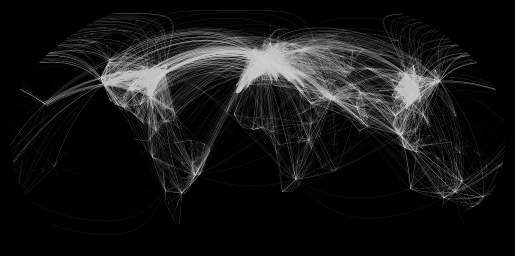

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
fig = plt.figure(facecolor='black')
ax = plt.axes(projection=ccrs.Robinson())
ax.patch.set_facecolor('black')

routes.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1)
ax.axis('off')

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

plt.show()


Finally, adding the airport symbology onto this map. We will scale the size of the symbol based on the number of flights that land there. customize the alpha value based on how frequently the route is used.

To do this, first add a new colun to the routes DataFrame to concatenate the source and destination airports for a unique route id. Then use NumPy's unique function to find all unique flights and their occurence counts and convert the unique routes and their counts into a new DataFrame. Finally, combine this new df with the original routes df to associate each route with freqeuency

In [17]:
routes['journey'] = routes['iata_source'] + '_' + routes['iata_destination']
journeys, counts = np.unique(routes['journey'], return_counts=True)
counts = pd.DataFrame({'journey': journeys, 'count': counts})
routes = pd.merge(routes, counts, on='journey')

# scale visibility based on trips
routes['alpha'] = 1 / (routes['count'] * 3)

In [37]:
# Calculate counts for source and destination airports
source_counts = (routes.source_airport.value_counts().reset_index(name='source_airport_count'))
destination_counts = (routes.destination_airport.value_counts().reset_index(name='destination_airport_count'))

# Merge the source and destination counts
airport_counts = pd.merge(source_counts, destination_counts, left_on='source_airport', right_on='destination_airport')

# Calculate total counts
airport_counts['count'] = (airport_counts['source_airport_count'] + airport_counts['destination_airport_count'])

# Merge with airports dataframe
airport_counts = pd.merge(airport_counts, airports, left_on='source_airport', right_on='iata')


In [49]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(airport_counts.long, airport_counts.lat)]
airport_counts = gpd.GeoDataFrame(airport_counts, geometry=geometry, crs='EPSG:4326')
airport_counts['markersize'] = airport_counts['count'] / 10

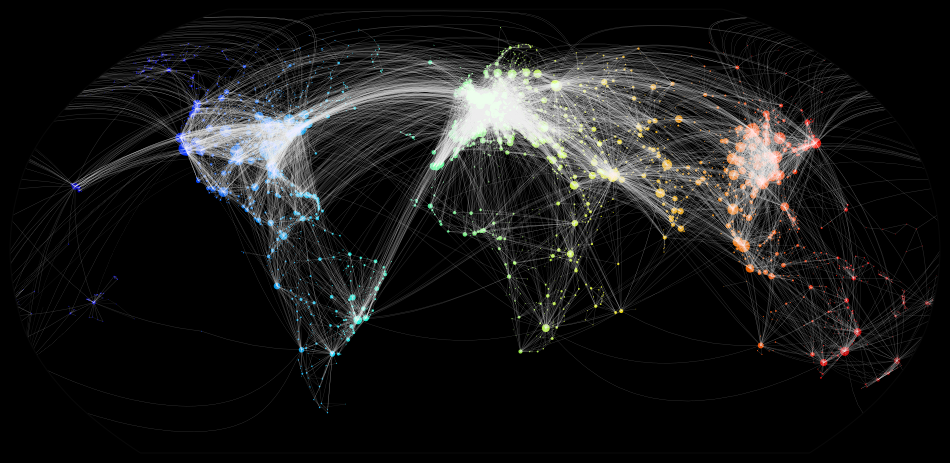

In [50]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(12,18), facecolor='black')
ax.patch.set_facecolor('black')

routes.plot(ax=ax, 
            transform=ccrs.Geodetic(), 
            color='white', 
            linewidth=routes['alpha'], 
            alpha=0.1)
airport_counts.plot(ax=ax, 
                    transform=ccrs.PlateCarree(), 
                    markersize=airport_counts['markersize'], 
                    alpha=0.9, 
                    cmap='jet',
                    column=airport_counts['long'],
                    edgecolors='none')

plt.setp(ax.spines.values(), color='#090909')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#090909')

plt.show()
